# CNN Caner Detection Mini Project 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
import random
import torch,torchvision
from torchvision import transforms
from torch.utils.data import random_split, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
import copy
import time
import numpy as np
from d2l import torch as d2l
from tqdm.notebook import trange, tqdm
import timm
from torchsummary import summary

## Description of the problem and data


The aim of this project is to use deep learning algorithms to identify metastatic cancer in small image patches extracted from larger digital pathology scans. 

The data for this project consists of a train folder, a test folder, a train_labels.csv file, and a sample_submission.csv file. The files in the train and test folders are named with an image ID. The train folder contains 220025 tif files, and the test folder contains 57458 tif files. The train_labels.csv file provides the labels for the images, where a positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. The total size of this dataset is 7.76 GB.

## Exploratory Data Analysis (EDA)

### Train Label Histogram

In [2]:
train_labels = pd.read_csv("./week3_data/train_labels.csv")
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


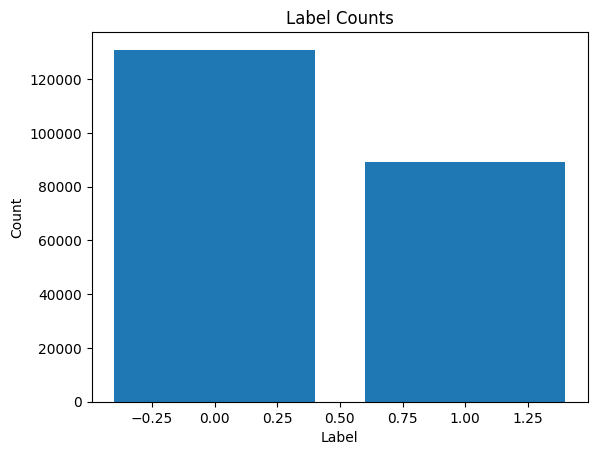

In [3]:
# Count the number of labels
counts = train_labels['label'].value_counts()

# Plot the counts
plt.bar(counts.index, counts.values)

# Add labels and title
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')

plt.show()

Based on the plot above, we can see that the train dataset contains 89117 positive images, which means 40% of the total images are positive.

### Image visualization

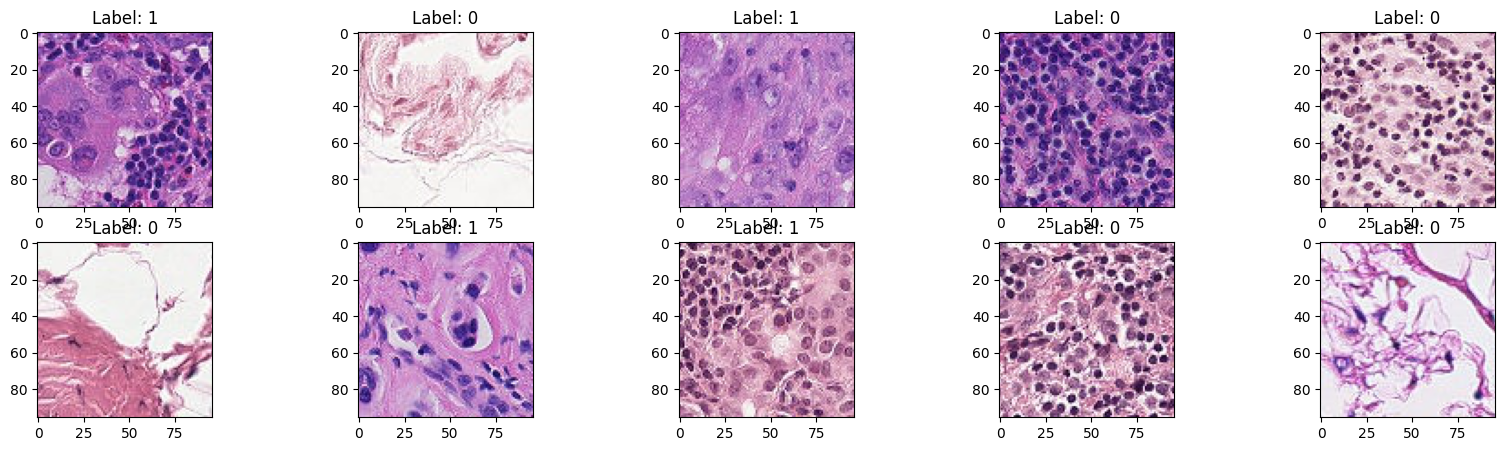

In [4]:
train_folder = "./week3_data/train/"
fig, axs = plt.subplots(2, 5, figsize=(20, 5))

random_indexes = random.sample(range(len(train_labels)), 10)

for i in range(10):
    index = random_indexes[i]
    row = train_labels.iloc[index]
    image_id = row['id']
    label = row['label']
    image_path = os.path.join(train_folder, f'{image_id}.tif')
    image = Image.open(image_path)
    axs[i // 5][i % 5].imshow(image)
    axs[i // 5][i % 5].set_title(f'Label: {label}')
    
plt.show()

It is very difficult to identify the positives from the images above.

In [5]:
## image dimension
im = Image.open(image_path) 
print('width：%d,height：%d' % (im.size[0],im.size[1]))

width：96,height：96


## Data Cleaning and Preparation

In [6]:
print(f'The train_label dataset has {sum(train_labels.duplicated())} duplicates')

The train_label dataset has 0 duplicates


In [7]:
print(f'The train_label dataset has {sum(train_labels.isnull().sum())} nulls')

The train_label dataset has 0 nulls


We define a ImageLabelReader class to prepare the images for training and testing in pytorch.

In [8]:
class ImageLabelReader:
    def __init__(self, img_path, label_csv_path, transform):
        self.img_path = img_path
        self.label_csv = pd.read_csv(label_csv_path)
        self.transform = transform

    def __getitem__(self, index):
        img_id = self.label_csv.iloc[index]['id']
        img_label = self.label_csv.iloc[index]['label']
        img = Image.open(os.path.join(self.img_path, f'{img_id}.tif'))
        img = self.transform(img)
        return img, img_label

    def __len__(self):
        return len(self.label_csv)

In [9]:
img_path = './week3_data/train/'
label_path = './week3_data/train_labels.csv'
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((64,64))])
img_reader = ImageLabelReader(img_path, label_path, data_transformer)
img, label = img_reader[0]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 64, 64]) tensor(0.0843) tensor(1.)


### Split the Dataset

In [10]:
data_size = len(img_reader)
train_size = int(0.9 * data_size)
val_size = data_size - train_size

train_data, val_data = random_split(img_reader, [train_size, val_size])

print(f'train dataset size: {len(train_data)}')
print(f'validation dataset size: {len(val_data)}')

train dataset size: 198022
validation dataset size: 22003


### Transform to Dataloader

In [11]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.RandomRotation(45)])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64, 64))])

train_data.transform=train_transform
val_data.transform=val_transform
val_data.transform

Compose(
    ToTensor()
    Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
)

In [12]:
train_loader = DataLoader(dataset = train_data, batch_size = 32, shuffle=True, num_workers=0)
val_loader = DataLoader(dataset= val_data, batch_size = 32, num_workers=0)

print(len(train_loader))
print(len(val_loader))

for x, y in train_loader:
    print(x.shape)
    print(y.shape)
    break
    

for x, y in val_loader:
    print(x.shape)
    print(y.shape)
    break

6189
688
torch.Size([32, 3, 64, 64])
torch.Size([32])
torch.Size([32, 3, 64, 64])
torch.Size([32])


## DModel Architecture

In this part, we train our models using simple LeNet and Resnet.

### Train Helper Function

In [13]:
## using d2l function
def evaluate_accuracy(net, data_iter, device=None): 
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    metric = d2l.Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(d2l.accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in tqdm(range(num_epochs), leave=False):
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')
    
def predict(model, dataset, device, num_classes=2):
    len_data=len(dataset)
    y_out=torch.zeros(len_data,num_classes)
    y_gt=np.zeros((len_data),dtype="uint8")
    model=model.to(device) 
    model.eval()
    
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y=dataset[i]
            y_gt[i]=y
            y_out[i]=model(x.unsqueeze(0).to(device))

    return y_out.numpy(),y_gt           


### LeNet 

In [14]:
lenet_model = nn.Sequential(
    nn.Conv2d(3, 6, kernel_size=5, padding=2), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(3136, 120), nn.Sigmoid(),   
    nn.Linear(120, 84), nn.Sigmoid(),
    nn.Linear(84, 2))

#### LeNet Architecture

In [25]:
summary(lenet_model,(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 64, 64]             456
           Sigmoid-2            [-1, 6, 64, 64]               0
         AvgPool2d-3            [-1, 6, 32, 32]               0
            Conv2d-4           [-1, 16, 28, 28]           2,416
           Sigmoid-5           [-1, 16, 28, 28]               0
         AvgPool2d-6           [-1, 16, 14, 14]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 120]         376,440
           Sigmoid-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
          Sigmoid-11                   [-1, 84]               0
           Linear-12                    [-1, 2]             170
Total params: 389,646
Trainable params: 389,646
Non-trainable params: 0
-------------------------------

### ResNet

In [27]:
resnet_model = timm.create_model("resnet18", pretrained=False, num_classes=2)

#### ResNet Architecture

In [28]:
summary(resnet_model,(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
          Identity-7           [-1, 64, 16, 16]               0
              ReLU-8           [-1, 64, 16, 16]               0
          Identity-9           [-1, 64, 16, 16]               0
           Conv2d-10           [-1, 64, 16, 16]          36,864
      BatchNorm2d-11           [-1, 64, 16, 16]             128
             ReLU-12           [-1, 64, 16, 16]               0
       BasicBlock-13           [-1, 64, 16, 16]               0
           Conv2d-14           [-1, 64,

## Result Analysis

From the above training process, we choose CrossEntropy as loss function and SGD as optimization method. 
1. With a learning rate of 0.1 and 10 epochs, LeNet can achieve a test accuracy of 0.795. 
2. With a learning rate of 0.1 and 10 epochs, ResNet exhibits obvious overfitting problems, as its training accuracy can achieve 0.953 but its test accuracy is only 0.664.
3. When we reduce epochs to 2, the ResNet can obtain higher test accuracy of 0.813, closer to LeNet.


#### LeNet training result

loss 0.442, train acc 0.798, test acc 0.795
3386.1 examples/sec on mps


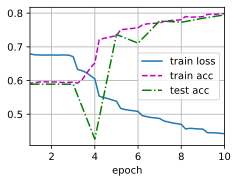

In [109]:
lr, num_epochs = 0.1, 10
train(lenet_model, train_loader, val_loader, num_epochs, lr, "mps")
torch.save(lenet_model.state_dict(), './lenet_weights.pt')

#### ResNet training result

loss 0.124, train acc 0.953, test acc 0.664
509.3 examples/sec on mps


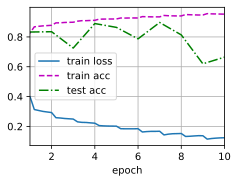

In [113]:
lr, num_epochs = 0.1, 10
train(resnet_model, train_loader, val_loader, num_epochs, lr, "mps")
torch.save(resnet_model.state_dict(), './resnet_weights_10epochs.pt')

loss 0.299, train acc 0.874, test acc 0.813
510.4 examples/sec on mps


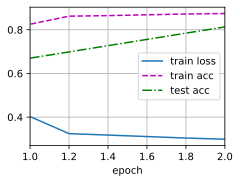

In [117]:
lr, num_epochs = 0.1, 2
train(resnet_model2, train_loader, val_loader, num_epochs, lr, "mps")
torch.save(resnet_model2.state_dict(), './resnet_weights_2epochs.pt')

## Kaggle Submission Predict

After submission, we find that LeNet preforms better than ResNet on test data, with 0.81 score.

In [119]:
img_path = './week3_data/test/'
label_path = './week3_data/sample_submission.csv'
data_transformer = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((64,64))])
img_reader_test = ImageLabelReader(img_path, label_path, data_transformer)
img, label = img_reader_test[0]
print(img.shape, torch.min(img), torch.max(img))

torch.Size([3, 64, 64]) tensor(0.1233) tensor(0.9775)


In [120]:
test_loader = DataLoader(dataset= img_reader_test, batch_size = 32, num_workers=0)

In [121]:
def predict(model, dataset, device, num_classes=2):
    len_data=len(dataset)
    y_out=torch.zeros(len_data,num_classes) 
    y_gt=np.zeros((len_data),dtype="uint8")
    model=model.to(device) 
    model.eval()
    
    with torch.no_grad():
        for i in tqdm(range(len_data)):
            x,y=dataset[i]
            y_gt[i]=y
            y_out[i]=model(x.unsqueeze(0).to(device))

    return y_out.numpy(),y_gt

In [129]:
#model.load_state_dict(torch.load('./lenet_weights.pt'))
y_test_out,_ = predict(lenet_model,img_reader_test, "cpu")  
y_test_pred=np.argmax(y_test_out,axis=1)
submission = img_reader_test.label_csv
submission.label = y_test_pred
submission.to_csv('./submission1.csv', index=False)

  0%|          | 0/57458 [00:00<?, ?it/s]

## Conclusion

In this project, we performed data cleaning and exploratory data analysis on the cancer dataset. 
We used the PyTorch, D2L and TIMM libraries to build and train models. 
Different architectures and hyperparameters were tried to find an optimal model. The overfitting issue was addressed in this project.
After submission, LeNet achieved better performance on the test set than ResNet. The reason could be that LeNet is a simple convolutional network with few parameters, while ResNet is an extremely deep residual network with significantly more parameters than LeNet. On small datasets, simple models may converge and optimize more easily, whereas on large datasets, complex models can learn more features and achieve superior performance.

For future works, we can try LeNet model with other optimization methods and loss function. Also, we can use other advanced CNN model to solve this problem, even some pretrained models.